In [1]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, time
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import Lasso, LinearRegression

In [2]:
# Read data
# Change data path on your computer
data_path = 'earthquakes.csv'
data = pd.read_csv(data_path)
# Print the data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1137 non-null   object 
 1   magnitude        1137 non-null   float64
 2   type             1137 non-null   object 
 3   title            1137 non-null   object 
 4   date             1137 non-null   object 
 5   time             1137 non-null   int64  
 6   updated          1137 non-null   int64  
 7   url              1137 non-null   object 
 8   detailUrl        1137 non-null   object 
 9   felt             1137 non-null   int64  
 10  cdi              1137 non-null   int64  
 11  mmi              1137 non-null   int64  
 12  alert            764 non-null    object 
 13  status           1137 non-null   object 
 14  tsunami          1137 non-null   int64  
 15  sig              1137 non-null   int64  
 16  net              1137 non-null   object 
 17  code          

In [3]:
# Remove some features that aren't important for classify / clustering the alert of the earthquake
# Feature 'date' is already converted to float type in the original dataset 
data.drop(['id', 'date', 'title', 'url', 'detailUrl', 'ids', 'sources',
           'types', 'net', 'code', 'geometryType', 'status',
           'postcode', 'what3words', 'locationDetails'], axis=1, inplace=True)

# Replace Null value of column 'alert' to unknown 
data.fillna({'alert': 'unknown'}, inplace=True)

# NA-value columns will be filled by 'unknown' value
na_column = data.columns[data.isna().any()].tolist()

for column in na_column:
    data.fillna({column: 'unknown'}, inplace=True)

# String-value columns will be one-hot coding
string_columns = data.select_dtypes(include=['object']).columns.tolist()

# One-hot coding
for column in string_columns:
    dummies = pd.get_dummies(data[column], prefix='type')
    data.drop([column], axis=1, inplace=True)
    data = pd.concat([data, dummies], axis=1)

pd.DataFrame(data)

,magnitude,time,updated,felt,cdi,mmi,tsunami,sig,nst,dmin,...,type_Wushi,type_Yakutat,type_Yamgan,type_Yucaipa,type_Yucca Flat,type_Zaybak,type_Zendeh Jan District,type_دهستان جلگه چاه هاشم,type_دهستان مورموری,type_دهستان گهره
0,4.8,1726534182289,1726583895255,1893,6,5,0,994,37,0.28700,...,False,False,False,False,False,False,False,False,False,False
1,5.1,1726534182183,1726672002991,2042,6,5,0,1040,24,0.00000,...,False,False,False,False,False,False,False,False,False,False
2,3.7,1726485728190,1726637414586,1580,4,4,0,591,135,0.03294,...,False,False,False,False,False,False,False,False,False,False
3,3.9,1726333266539,1726584426218,5,3,4,0,236,38,0.00000,...,False,False,False,False,False,False,False,False,False,False
4,4.1,1726333266382,1726334616179,4,3,4,0,260,28,0.04300,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132,6.3,1696662769702,1702589215040,11,9,8,0,1010,244,5.90400,...,False,False,False,False,False,False,True,False,False,False
1133,5.4,1696661381156,1702589215040,0,0,7,0,650,165,5.85800,...,False,False,False,False,False,False,True,False,False,False
1134,6.3,1696660863327,1702589215040,19,8,8,0,1014,279,5.87200,...,False,False,False,False,False,False,True,False,False,False
1135,5.7,1696324863018,1702589211040,131,8,7,0,605,226,3.93000,...,False,False,False,False,False,False,False,False,False,False


In [4]:
# Sample set x_data and label set y_data 
x_data = data.drop(['cdi'], axis=1)
x_data = StandardScaler().fit_transform(x_data)
y_data = data['cdi']

In [5]:
# Function to split the training set and validation set
def split_data(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size=test_size,
                                                        random_state=42)
    return x_train, x_test, y_train, y_test

In [6]:
def evaluate_model(start_time, end_time, y_test, y_pred):
    print(f'Training time: {end_time - start_time}s')
    print(f'Mean Square Error: {mean_squared_error(y_test, y_pred)}')
    print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
    print(f'Root Mean Squared Error: {root_mean_squared_error(y_test, y_pred)}')
    print(f'R2 Score: {r2_score(y_test, y_pred)}')

In [7]:
def lasso_regression_approach(x_train, x_test, y_train, y_test):
    # Train the model
    start_time = time.perf_counter()
    lasso = Lasso(alpha=1.0)
    lasso.fit(x_train, y_train)
    end_time = time.perf_counter()
    
    # Predict the labels
    y_pred = lasso.predict(x_test)
    
    # Evaluate the model
    evaluate_model(start_time, end_time, y_test, y_pred)
    
    # Trực quan hóa
    plt.figure(figsize=(10, 6))
    
    # Biểu đồ scatter: dự đoán vs thực tế
    plt.scatter(y_test, y_pred, color='blue', label='Dự đoán vs Thực tế')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Đường hoàn hảo')
    
    plt.title('So sánh giữa Dự đoán và Thực tế')
    plt.xlabel('Giá trị Thực tế')
    plt.ylabel('Giá trị Dự đoán')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [8]:
def linear_regression_approach(x_train, x_test, y_train, y_test):
    # Train the model
    start_time = time.perf_counter()
    linear = LinearRegression()
    linear.fit(x_train, y_train)
    end_time = time.perf_counter()
    
    # Predict the labels
    y_pred = linear.predict(x_test)
    
    # Evaluate the model
    evaluate_model(start_time, end_time, y_test, y_pred)
    
    # Trực quan hóa
    plt.figure(figsize=(10, 6))
    
    # Biểu đồ scatter: dự đoán vs thực tế
    plt.scatter(y_test, y_pred, color='blue', label='Dự đoán vs Thực tế')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Đường hoàn hảo')
    
    plt.title('So sánh giữa Dự đoán và Thực tế')
    plt.xlabel('Giá trị Thực tế')
    plt.ylabel('Giá trị Dự đoán')
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [9]:
def classification(x_train, x_test, y_train, y_test):
    print('Lasso Regression approach')
    lasso_regression_approach(x_train, x_test, y_train, y_test)
    print('\nLinear Regression approach')
    linear_regression_approach(x_train, x_test, y_train, y_test)
    
# This function classifies based on the original data
def original_data(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = split_data(x_data, y_data, test_size)
    print(f'Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: {int((1 - test_size) * 10)}:{int(test_size * 10)}')
    classification(x_train, x_test, y_train, y_test)


# This function first reduces dimensionality, then splits the data into train and validation sets, and finally classifies
def dim_reduction_split(x_data, y_data, test_size, dim_reduction_type, dim):
    if (dim_reduction_type == 'pca'):
        pca = PCA(n_components=dim, random_state=42)
        x_data_dim_reduction = pca.fit_transform(x_data)
    elif (dim_reduction_type == 'lda'):
        lda = LDA(n_components=dim)
        x_data_dim_reduction = lda.fit_transform(x_data, y_data)

    x_train, x_test, y_train, y_test = split_data(x_data_dim_reduction, y_data, test_size)
    print(f'Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: {int((1 - test_size) * 10)}:{int(test_size * 10)}')
    classification(x_train, x_test, y_train, y_test)


# This function first splits the data into train and validation sets, then reduces dimensionality, and finally classifies
def split_dim_reduction(x_data, y_data, test_size, dim_reduction_type, dim):
    x_train, x_test, y_train, y_test = split_data(x_data, y_data, test_size)

    if (dim_reduction_type == 'pca'):
        pca = PCA(n_components=dim, random_state=42)
        x_train_dim_reduction = pca.fit_transform(x_train)
        x_test_dim_reduction = pca.transform(x_test)
    elif (dim_reduction_type == 'lda'):
        lda = LDA(n_components=dim)
        x_train_dim_reduction = lda.fit_transform(x_train, y_train)
        x_test_dim_reduction = lda.transform(x_test)

    print(f'Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: {int((1 - test_size) * 10)}:{int(test_size * 10)} rồi giảm chiều')
    classification(x_train_dim_reduction, x_test_dim_reduction, y_train, y_test)

Giảm còn $\dfrac{1}{3}$ số chiều 


In [10]:
dim_pca = x_data.shape[1] // 3
dim_lda = len(set(y_data)) // 3

### Thực hiện phân loại trên tập dữ liệu gốc
***Tỷ lệ train:test là 4:1***

Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: 8:2
Lasso Regression approach
Training time: 0.12778079999998226s
Mean Square Error: 4.920850368970213
Mean Absolute Error: 1.8763452631012258
Root Mean Squared Error: 2.2182989809694753
R2 Score: 0.19054020131463978


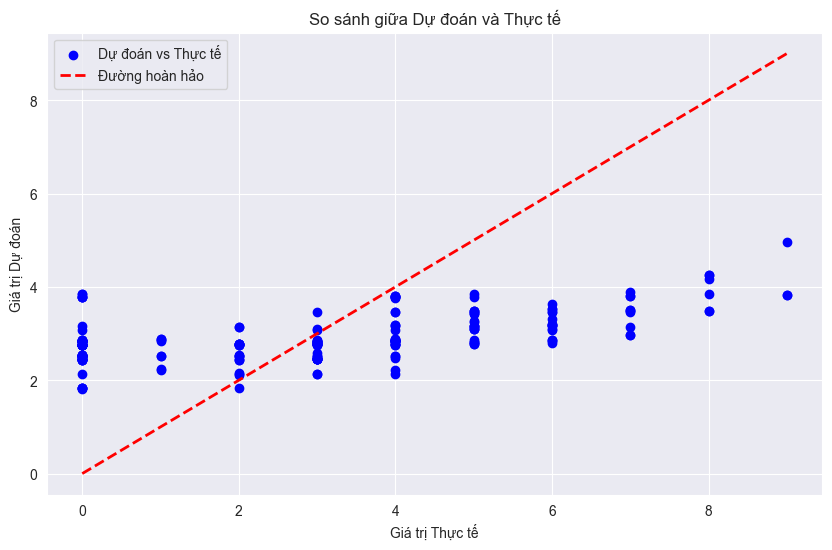


Linear Regression approach
Training time: 2.0565463000000364s
Mean Square Error: 9.97490045675018e+27
Mean Absolute Error: 39247158106560.15
Root Mean Squared Error: 99874423436384.25
R2 Score: -1.640830407390992e+27


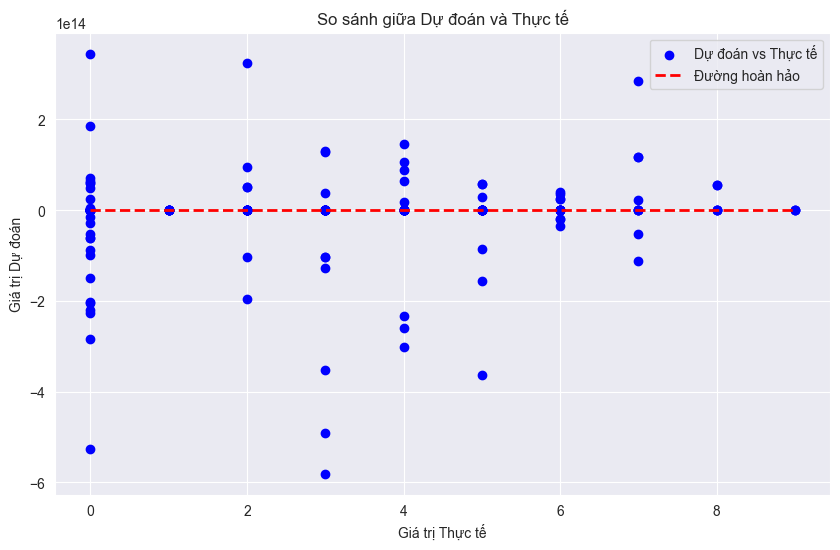

In [11]:
original_data(x_data, y_data, 0.2)

***Tỷ lệ train:test là 7:3***

Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: 7:3
Lasso Regression approach
Training time: 0.09847990000002937s
Mean Square Error: 4.682878165926289
Mean Absolute Error: 1.8419698717341908
Root Mean Squared Error: 2.163995879369064
R2 Score: 0.19159287746937081


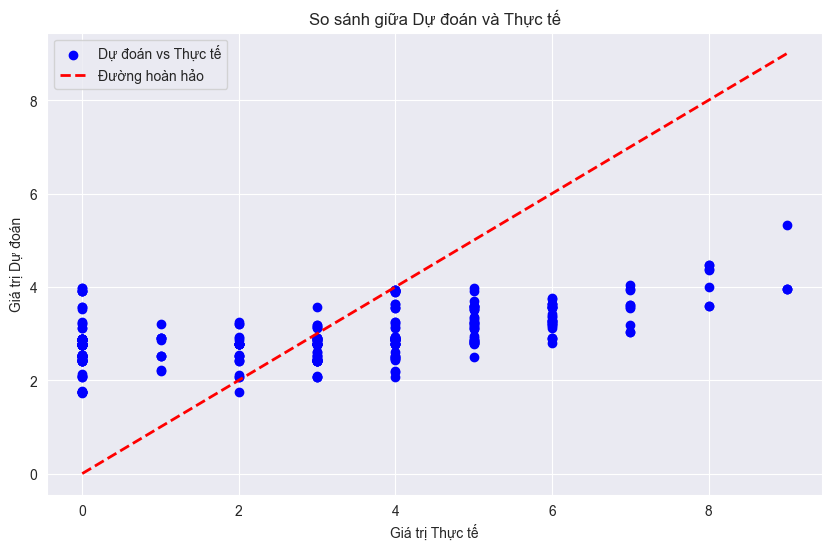


Linear Regression approach
Training time: 0.36772880000012265s
Mean Square Error: 5.490400064401431e+28
Mean Absolute Error: 48110718493779.055
Root Mean Squared Error: 234316027287964.9
R2 Score: -9.478099494238703e+27


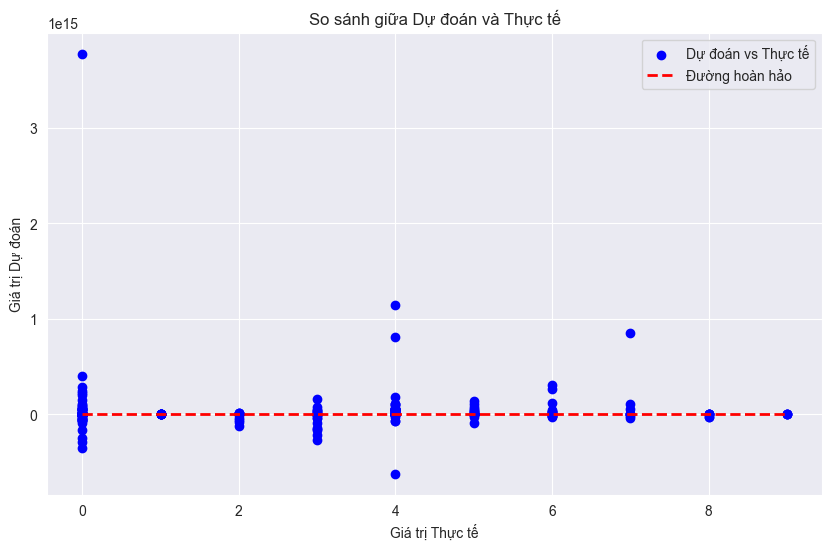

In [12]:
original_data(x_data, y_data, 0.3)

***Tỷ lệ train:test là 6:4***

Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: 6:4
Lasso Regression approach
Training time: 0.030725200000006225s
Mean Square Error: 4.921686966127483
Mean Absolute Error: 1.9050637610869212
Root Mean Squared Error: 2.2184875402236277
R2 Score: 0.1983091094071523


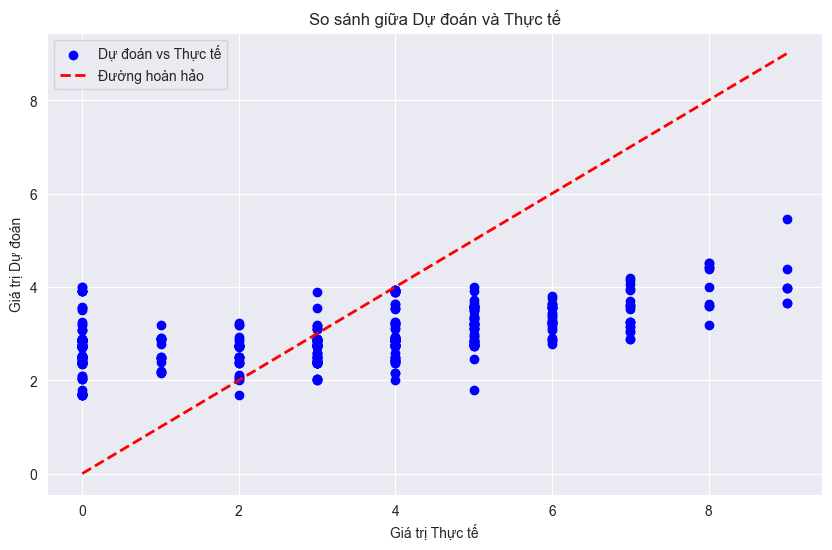


Linear Regression approach
Training time: 0.3499105000000782s
Mean Square Error: 1.2034653772104981e+28
Mean Absolute Error: 39738029090660.44
Root Mean Squared Error: 109702569578405.88
R2 Score: -1.960318152482335e+27


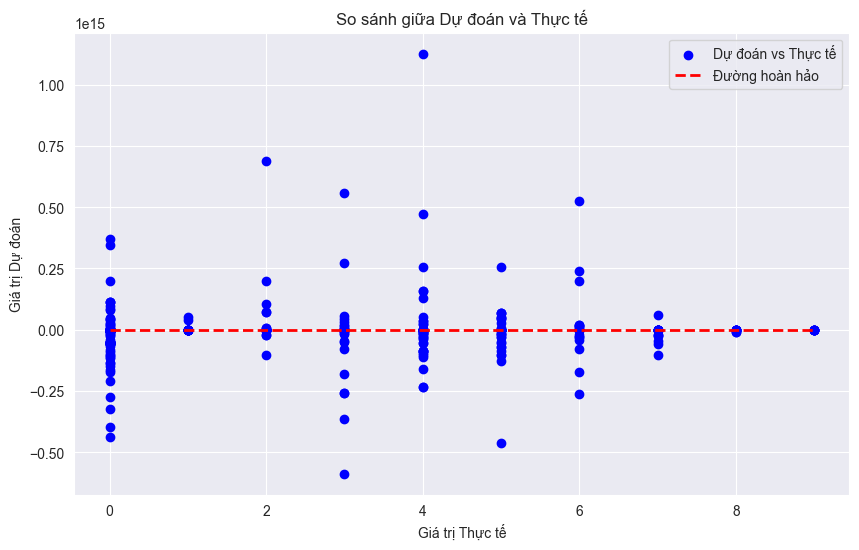

In [13]:
original_data(x_data, y_data, test_size=0.4)

### Thực hiện giảm chiều dữ liệu (bằng phương pháp PCA), chia tập train - validation, rồi phân loại

***Tỷ lệ train:test là 4:1***

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 8:2
Lasso Regression approach
Training time: 0.008925900000122056s
Mean Square Error: 4.769304440660749
Mean Absolute Error: 1.842004654045878
Root Mean Squared Error: 2.183873723606919
R2 Score: 0.21546888790801744


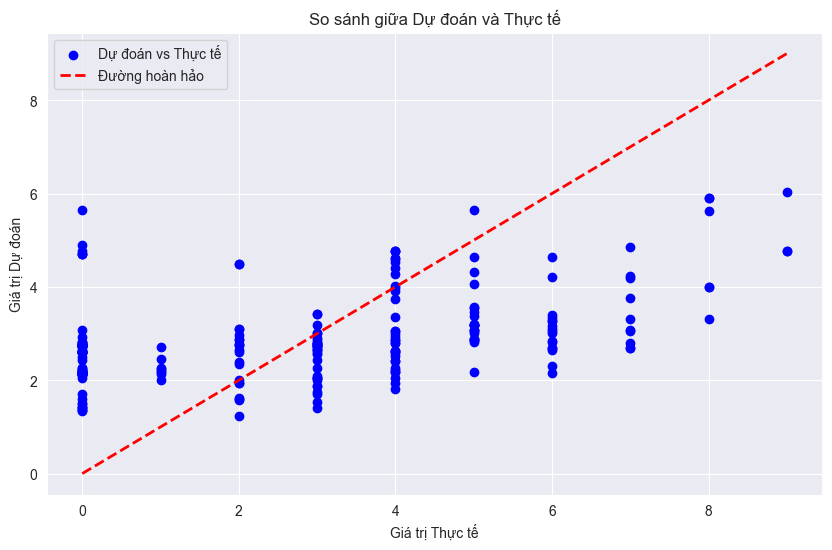


Linear Regression approach
Training time: 0.23762810000016543s
Mean Square Error: 1.3924876078758277e+29
Mean Absolute Error: 142870552510039.4
Root Mean Squared Error: 373160502716435.4
R2 Score: -2.2905852733313405e+28


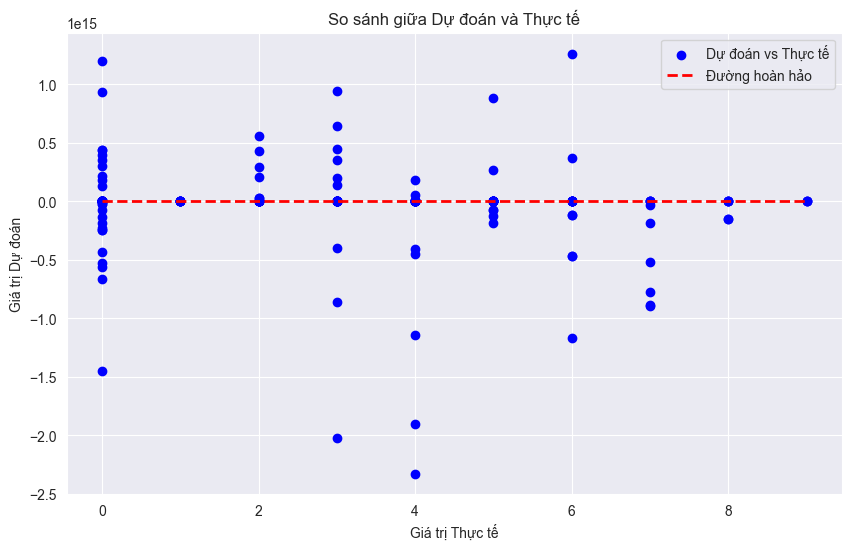

In [14]:
dim_reduction_split(x_data, y_data, dim_reduction_type='pca', test_size=0.2, dim=dim_pca)

***Tỷ lệ train:test là 7:3***

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 7:3
Lasso Regression approach
Training time: 0.007400100000040766s
Mean Square Error: 4.5001779783194795
Mean Absolute Error: 1.8102557241043107
Root Mean Squared Error: 2.121362293037066
R2 Score: 0.22313248360811222


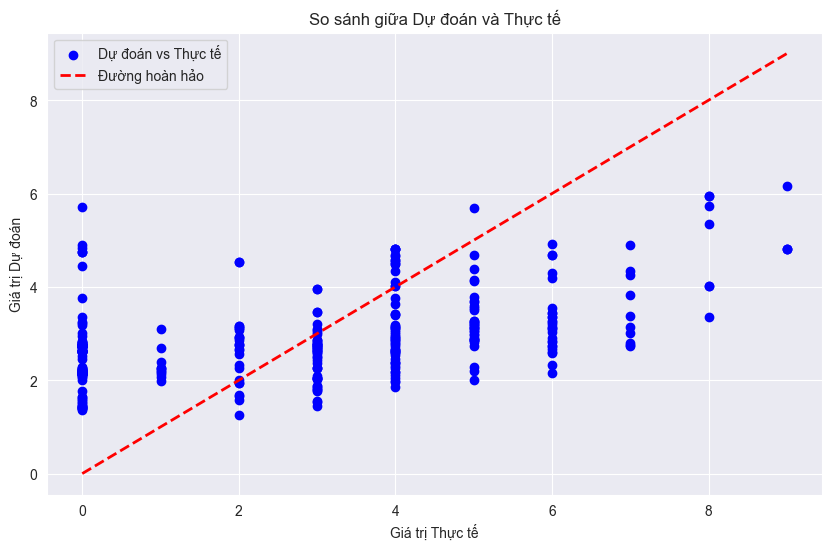


Linear Regression approach
Training time: 0.2826425000000654s
Mean Square Error: 1.4993637850898823e+29
Mean Absolute Error: 191822416775532.3
Root Mean Squared Error: 387216190917926.7
R2 Score: -2.5883576727463027e+28


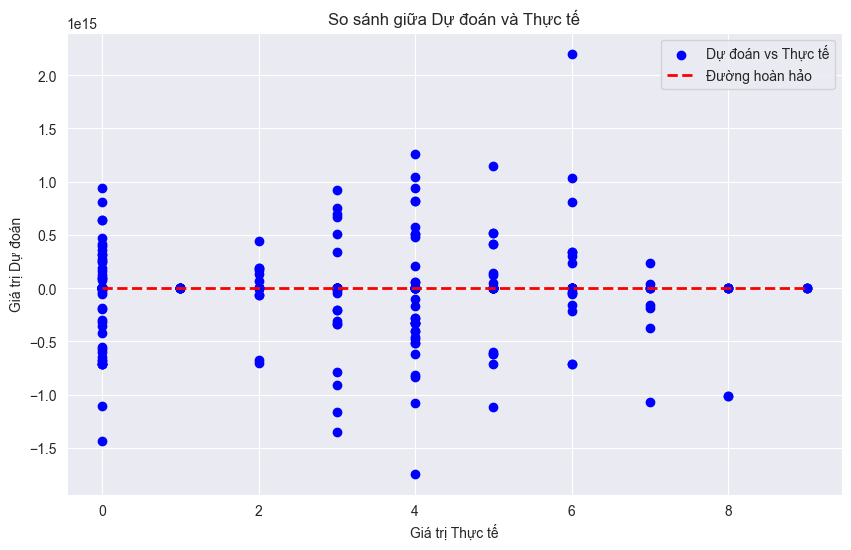

In [15]:
dim_reduction_split(x_data, y_data, dim_reduction_type='pca', test_size=0.3, dim=dim_pca)

***Tỷ lệ train:test là 6:4***

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 6:4
Lasso Regression approach
Training time: 0.007044199999882039s
Mean Square Error: 4.833744765223171
Mean Absolute Error: 1.883438178663831
Root Mean Squared Error: 2.198577896100834
R2 Score: 0.21263396628019027


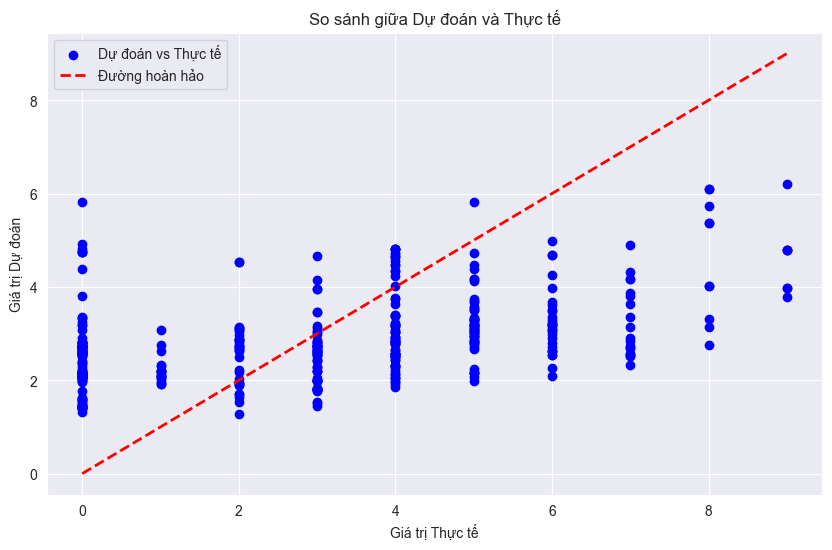


Linear Regression approach
Training time: 0.29892610000001696s
Mean Square Error: 1.5996109593391362e+29
Mean Absolute Error: 196662069520538.3
Root Mean Squared Error: 399951366960926.44
R2 Score: -2.6055975185347747e+28


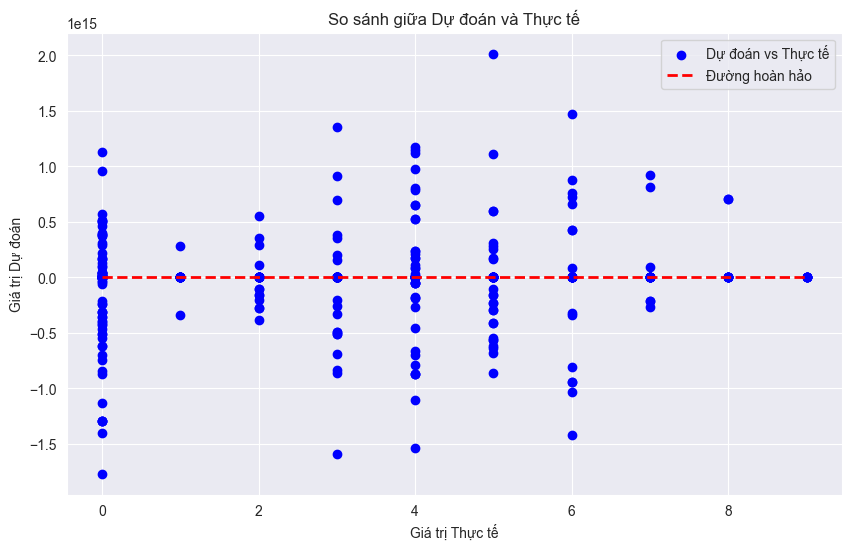

In [16]:
dim_reduction_split(x_data, y_data, dim_reduction_type='pca', test_size=0.4, dim=dim_pca)

### Thực hiện giảm chiều dữ liệu (bằng phương pháp LDA), chia tập train - validation, rồi phân loại

***Tỷ lệ train:test là 4:1***

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 8:2
Lasso Regression approach
Training time: 0.0026867999999922176s
Mean Square Error: 3.6595294377216856
Mean Absolute Error: 1.6142648005278006
Root Mean Squared Error: 1.9129896595961218
R2 Score: 0.39802234576759676


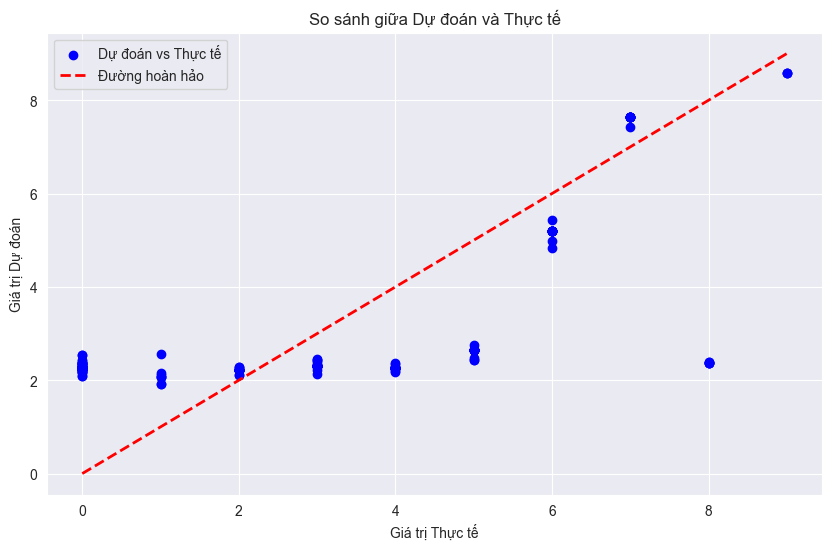


Linear Regression approach
Training time: 0.0016094000000066444s
Mean Square Error: 3.6441913473810454
Mean Absolute Error: 1.6008355441731725
Root Mean Squared Error: 1.90897651828959
R2 Score: 0.4005453990182386


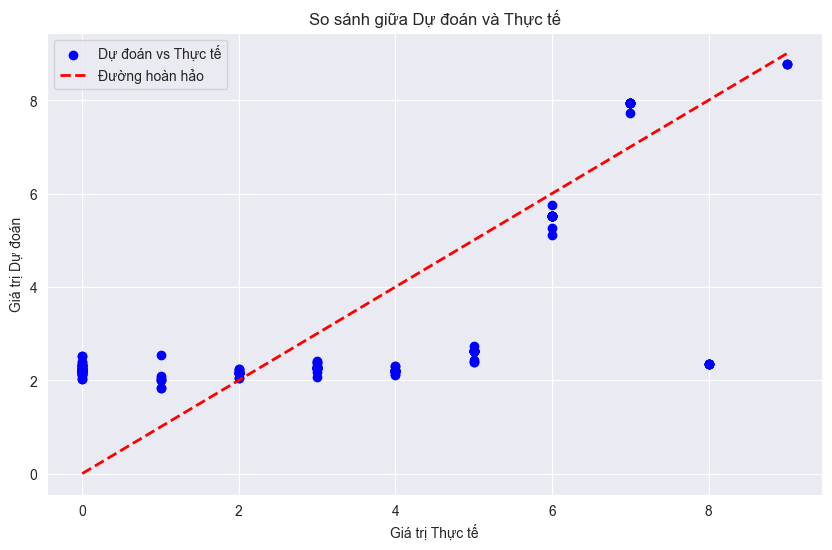

In [17]:
dim_reduction_split(x_data, y_data, dim_reduction_type='lda', test_size=0.2, dim=dim_lda)

***Tỷ lệ train:test là 7:3***

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 7:3
Lasso Regression approach
Training time: 0.0012735000000247965s
Mean Square Error: 3.593279080649514
Mean Absolute Error: 1.6330468467784325
Root Mean Squared Error: 1.8955946509339792
R2 Score: 0.3796908014448006


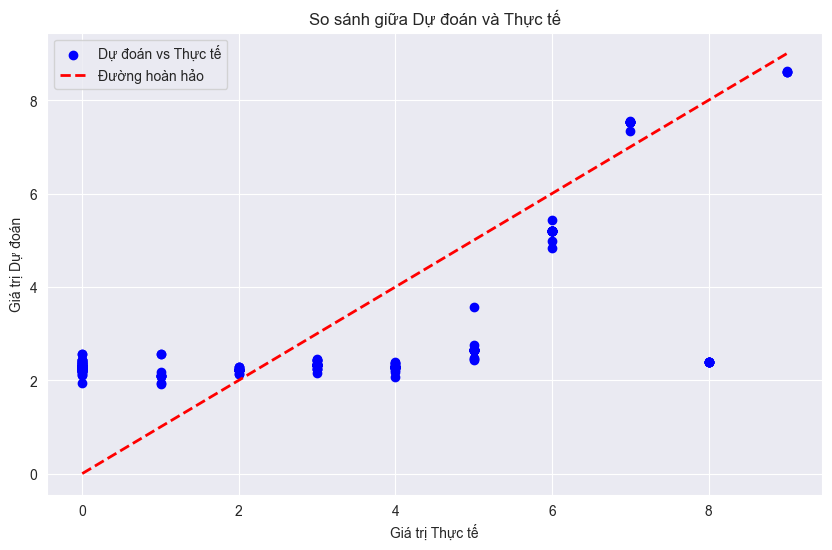


Linear Regression approach
Training time: 0.0013524999999390275s
Mean Square Error: 3.5669775377610318
Mean Absolute Error: 1.6144227492380678
Root Mean Squared Error: 1.8886443650833344
R2 Score: 0.3842312472670524


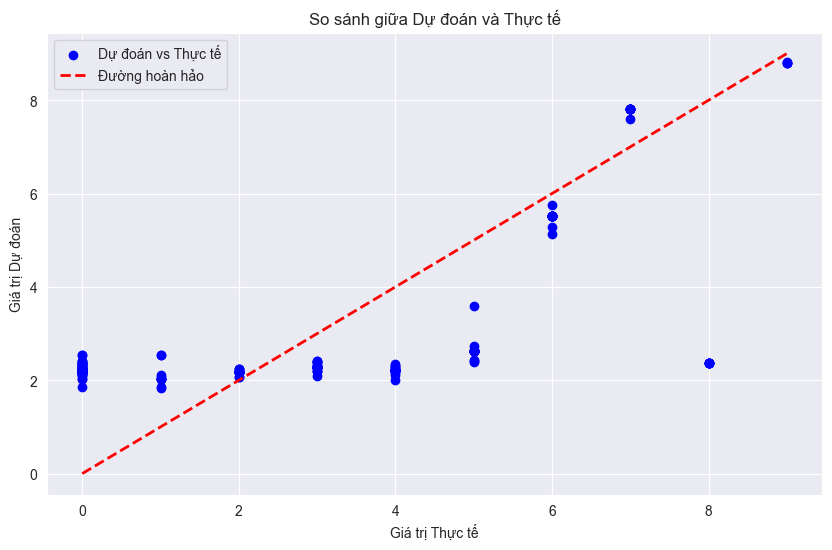

In [18]:
dim_reduction_split(x_data, y_data, dim_reduction_type='lda', test_size=0.3, dim=dim_lda)

***Tỷ lệ train:test là 6:4***


Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 6:4
Lasso Regression approach
Training time: 0.0014974999999139982s
Mean Square Error: 3.6946021184318276
Mean Absolute Error: 1.6521336833426146
Root Mean Squared Error: 1.9221347815467644
R2 Score: 0.3981882872485164


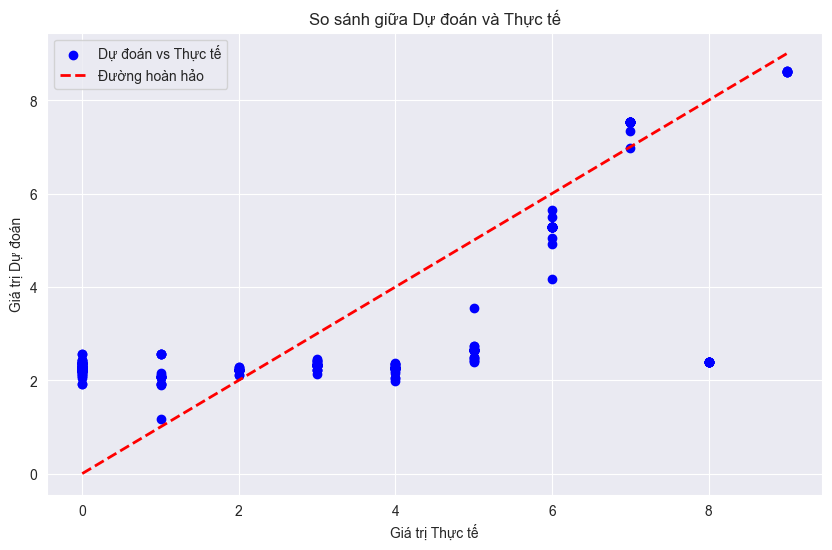


Linear Regression approach
Training time: 0.0013291999998727988s
Mean Square Error: 3.680115037018239
Mean Absolute Error: 1.6405190232281255
Root Mean Squared Error: 1.9183625926863355
R2 Score: 0.40054807999447595


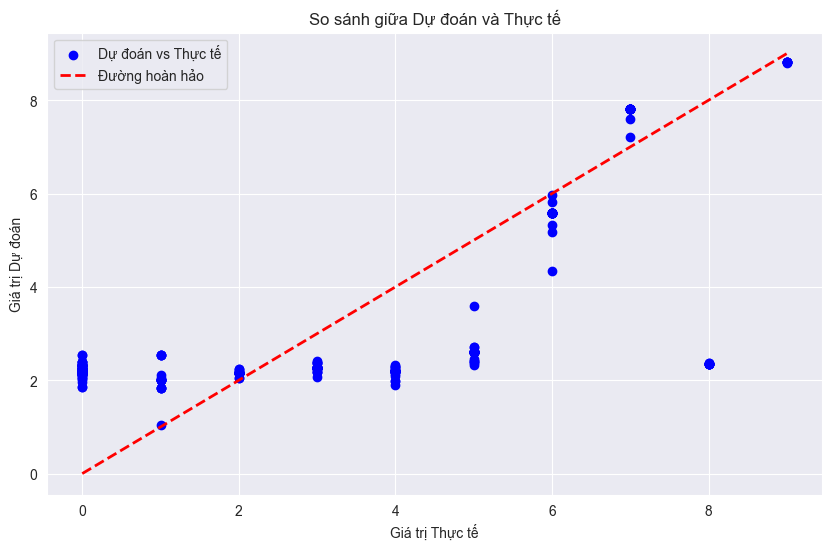

In [19]:
dim_reduction_split(x_data, y_data, dim_reduction_type='lda', test_size=0.4, dim=dim_lda)

### Thực hiện chia tập train - validation, giảm chiều dữ liệu (bằng phương pháp PCA), rồi phân loại

***Tỷ lệ train:test là 4:1***

Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: 8:2 rồi giảm chiều
Lasso Regression approach
Training time: 0.02601079999999456s
Mean Square Error: 5.076078269538058
Mean Absolute Error: 1.9048009913468171
Root Mean Squared Error: 2.253015372681256
R2 Score: 0.16500584531464335


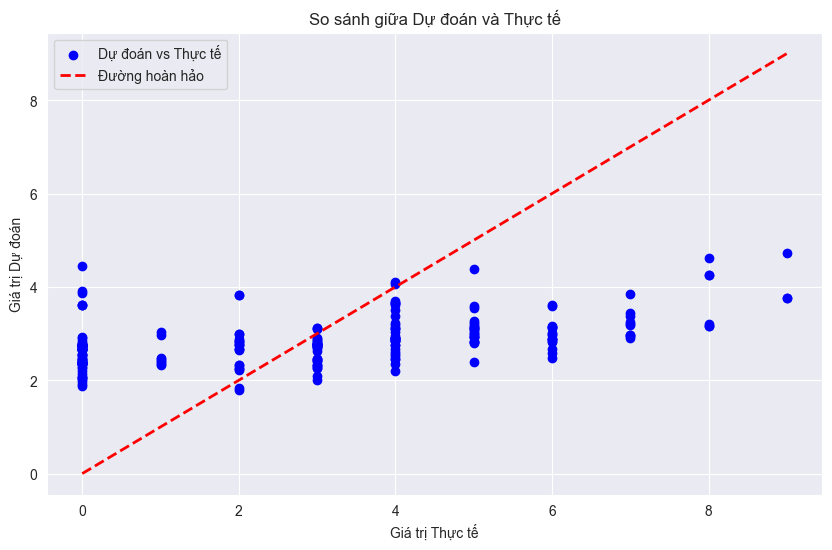


Linear Regression approach
Training time: 0.20835830000009992s
Mean Square Error: 1.4825949701001177e+25
Mean Absolute Error: 1591039541661.4636
Root Mean Squared Error: 3850447987053.088
R2 Score: -2.438808205989637e+24


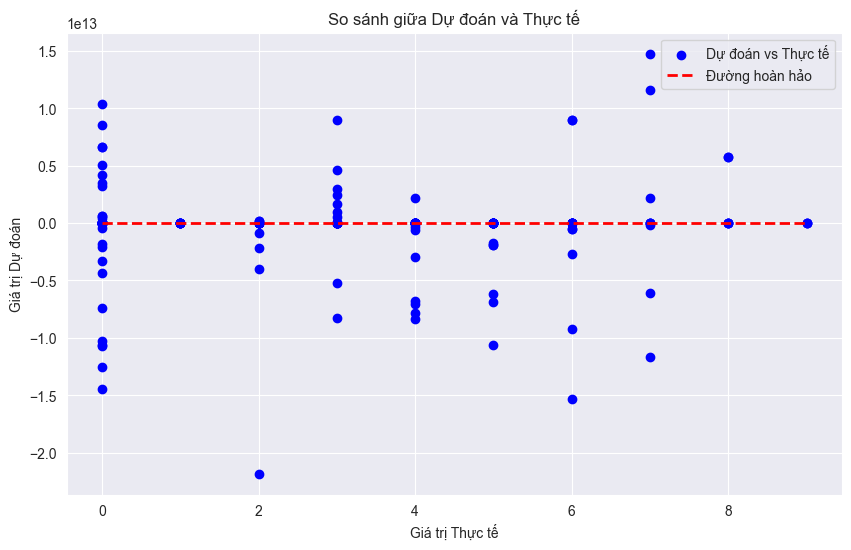

In [20]:
split_dim_reduction(x_data, y_data, dim_reduction_type='pca', test_size=0.2, dim=dim_pca)

***Tỷ lệ train:test là 7:3***

Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: 7:3 rồi giảm chiều
Lasso Regression approach
Training time: 0.007860100000016246s
Mean Square Error: 4.978165644091666
Mean Absolute Error: 1.9004638402269547
Root Mean Squared Error: 2.2311803253192393
R2 Score: 0.14061728252865124


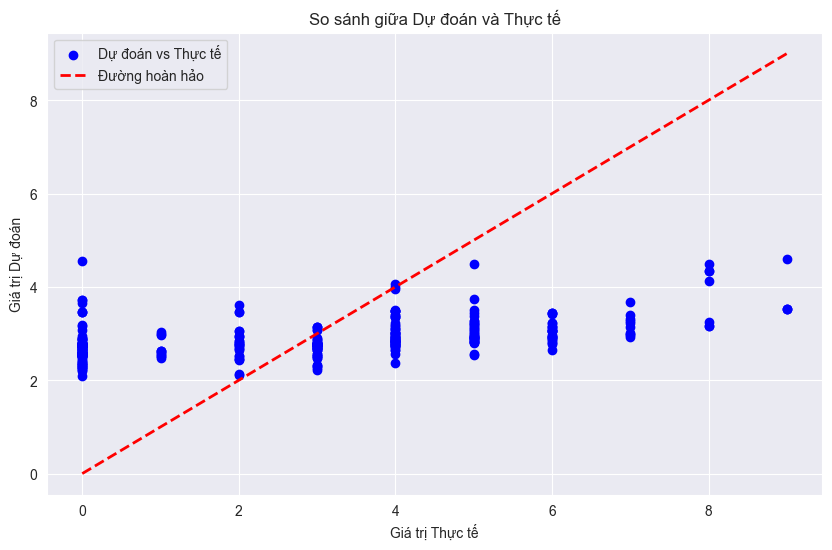


Linear Regression approach
Training time: 0.20607449999988603s
Mean Square Error: 9.0880779466914e+27
Mean Absolute Error: 44631361392514.77
Root Mean Squared Error: 95331411122942.06
R2 Score: -1.5688785148578873e+27


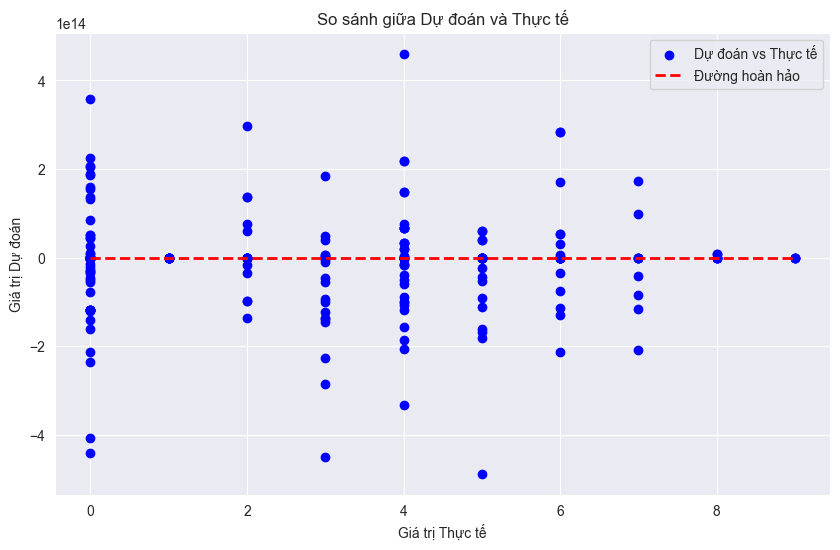

In [21]:
split_dim_reduction(x_data, y_data, dim_reduction_type='pca', test_size=0.3, dim=dim_pca)

***Tỷ lệ train:test là 6:4***


Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: 6:4 rồi giảm chiều
Lasso Regression approach
Training time: 0.012101200000188328s
Mean Square Error: 5.39777735742939
Mean Absolute Error: 1.9913841695524899
Root Mean Squared Error: 2.3233117219670265
R2 Score: 0.12075900668173722


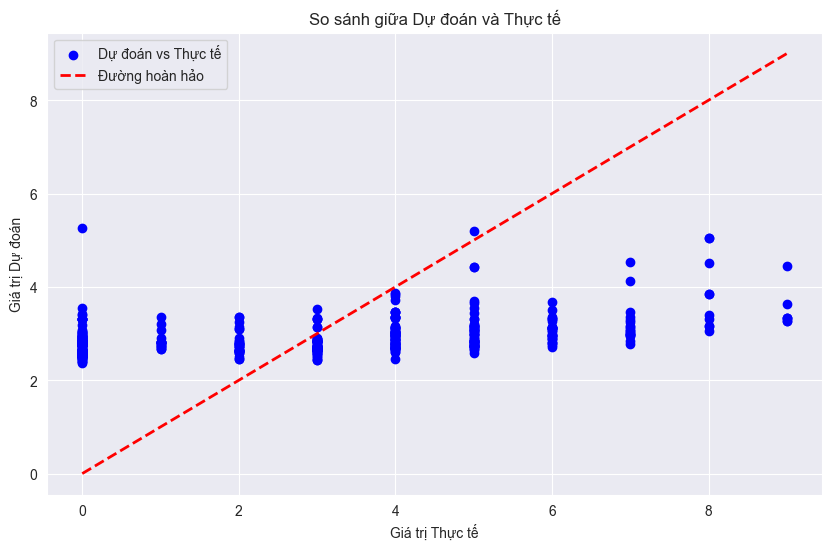


Linear Regression approach
Training time: 0.15129300000012336s
Mean Square Error: 1.2169543244566766e+28
Mean Absolute Error: 40459512166916.305
Root Mean Squared Error: 110315652763181.19
R2 Score: -1.9822902246709436e+27


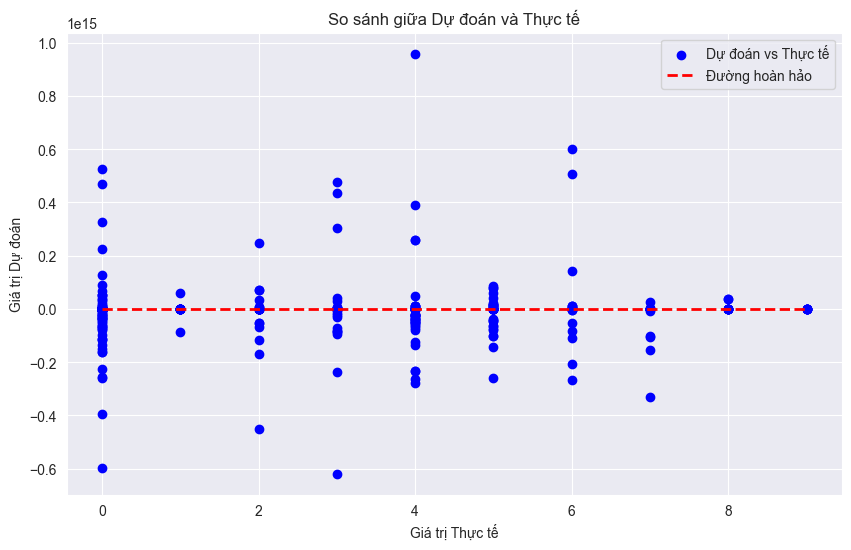

In [22]:
split_dim_reduction(x_data, y_data, dim_reduction_type='pca', test_size=0.4, dim=dim_pca)

### Thực hiện chia tập train - validation, giảm chiều dữ liệu (bằng phương pháp LDA), rồi phân loại

***Tỷ lệ train:test là 4:1***

Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: 8:2 rồi giảm chiều
Lasso Regression approach
Training time: 0.0020438999999896623s
Mean Square Error: 1.340387225837218e+30
Mean Absolute Error: 252142455996594.38
Root Mean Squared Error: 1157750934284752.8
R2 Score: -2.204882271625908e+29


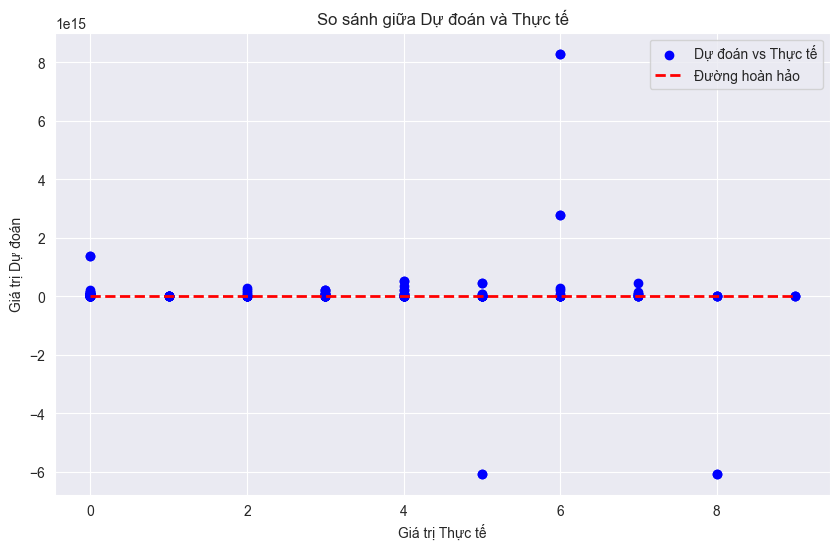


Linear Regression approach
Training time: 0.001899699999967197s
Mean Square Error: 1.6380631377182183e+30
Mean Absolute Error: 279520262308267.38
Root Mean Squared Error: 1279868406406775.2
R2 Score: -2.6945469954795222e+29


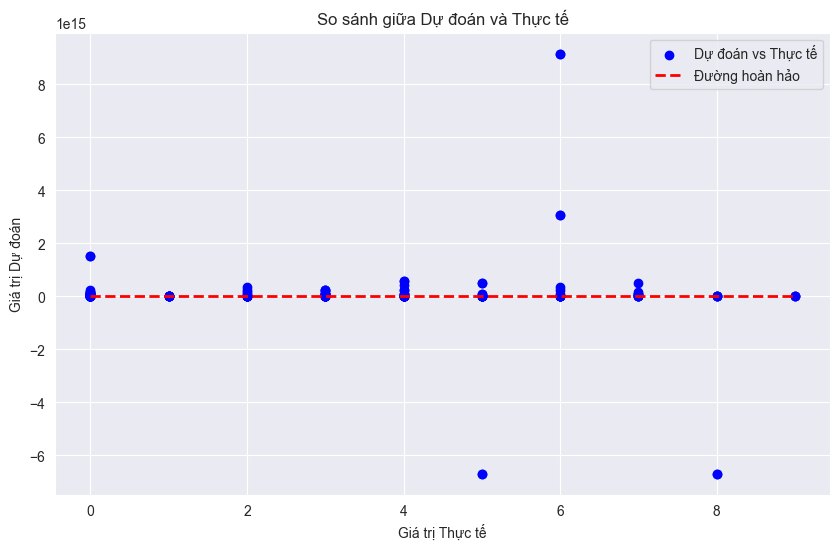

In [23]:
split_dim_reduction(x_data, y_data, dim_reduction_type='lda', test_size=0.2, dim=dim_lda)

***Tỷ lệ train:test là 7:3***

Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: 7:3 rồi giảm chiều
Lasso Regression approach
Training time: 0.0022945000000618165s
Mean Square Error: 3.0155837140692264e+28
Mean Absolute Error: 68289434216505.71
Root Mean Squared Error: 173654361133523.7
R2 Score: -5.205814173811037e+27


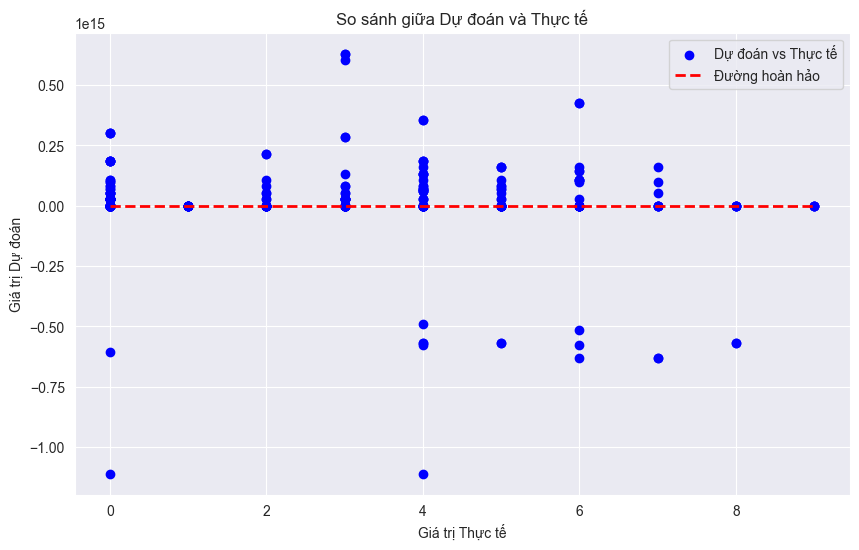


Linear Regression approach
Training time: 0.0010867999999391031s
Mean Square Error: 4.531493842776937e+28
Mean Absolute Error: 83941489826990.45
Root Mean Squared Error: 212873057073386.75
R2 Score: -7.82273586543321e+27


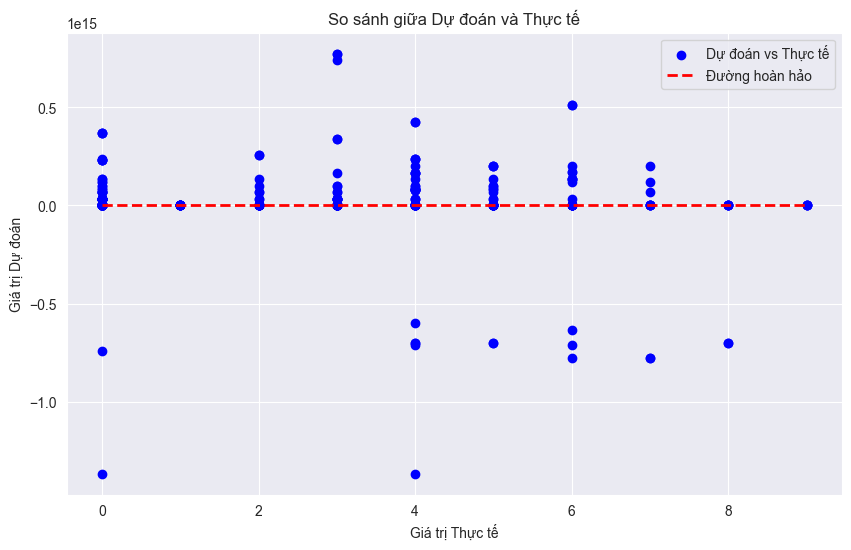

In [24]:
split_dim_reduction(x_data, y_data, dim_reduction_type='lda', test_size=0.3, dim=dim_lda)

***Tỷ lệ train:test là 6:4***

Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: 6:4 rồi giảm chiều
Lasso Regression approach
Training time: 0.001657500000192158s
Mean Square Error: 3.383755530778681e+29
Mean Absolute Error: 172778417658720.94
Root Mean Squared Error: 581700569948034.5
R2 Score: -5.511780825737646e+28


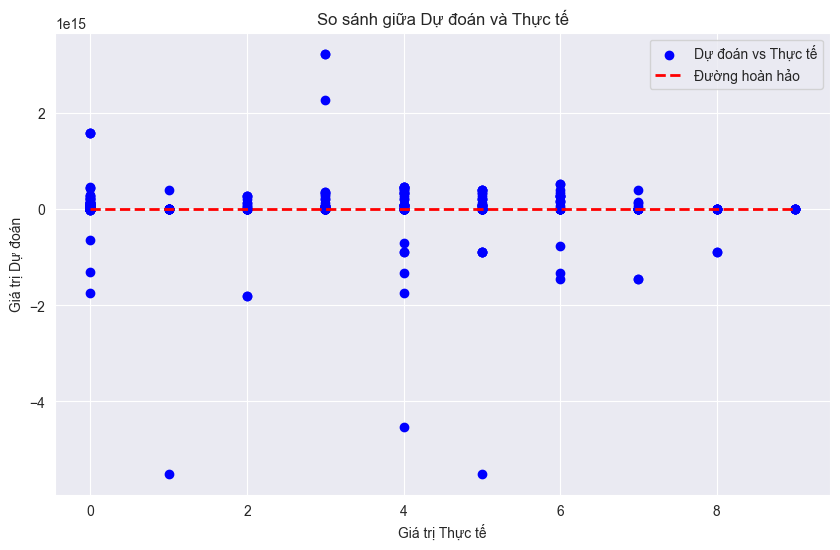


Linear Regression approach
Training time: 0.0010463000000981992s
Mean Square Error: 4.322451794612468e+29
Mean Absolute Error: 195419093581943.7
Root Mean Squared Error: 657453556885387.0
R2 Score: -7.040818021577856e+28


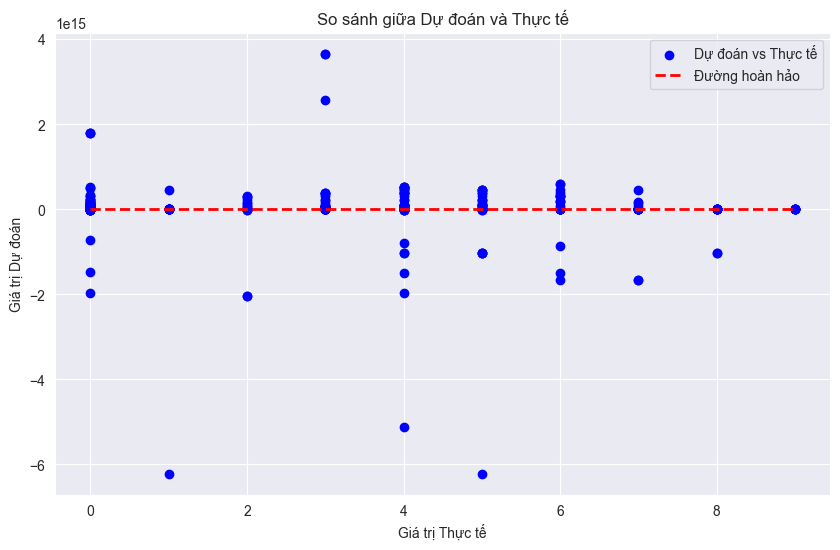

In [25]:
split_dim_reduction(x_data, y_data, dim_reduction_type='lda', test_size=0.4, dim=dim_lda)